In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
import math
!pip install pymc3
import pymc3 as pm
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 3.3 MB/s 
     |████████████████████████████████| 1.8 MB 13.3 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=c2077147aadcbf7b21ed43acf80870965e4bc873969ea92c07b99688d999c8cb
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


### Problem 1

In [3]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """


    # Since we assume there is a uniform prior the MLE = MAP
    domain = np.linspace(0, 1, 1000)
    sample = np.random.binomial(n, p)
    L = binom.pmf(sample, n, domain)
    posterior = L / (np.sum(L) * (domain[1] - domain[0]))

    # Plot the posterior
    plt.plot(domain, posterior)
    plt.title("Posterior Distribution of Bernonulli Sampling")
    plt.show()

    return domain[np.argmax(posterior)]



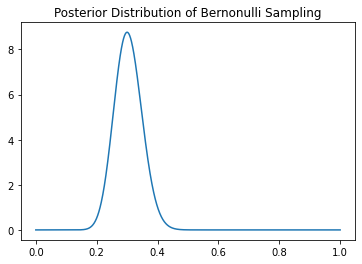

0.3003003003003003

In [4]:
# Run Problem 1
bernoulli_sampling(.2, 100)

### Problem 2

In [13]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    # Calculate Prior pdf and Posterior distribution
    domain = np.linspace(0, 1, 1000)
    sample = np.random.binomial(n, p)
    L = binom.pmf(sample, n, domain)
    prior_pdf = prior.pdf(domain)
    posterior = L * prior_pdf / (np.sum(L * prior_pdf) * (domain[1] - domain[0]))

    # Plot the posterior
    plt.subplot(122)
    plt.plot(domain, posterior)
    plt.title("Posterior Distribution Plot")
    plt.tight_layout()
    plt.show()

    return domain[np.argmax(posterior)]


In [ ]:
# Run Problem 2
beta_prior = beta(5, 1.5)
print(non_uniform_prior(.4, 20, beta_prior))
print(non_uniform_prior(.9, 20, beta_prior))

###Problem 3

In [15]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. Return a list of strings, not including the 0th day.
    """
    labels = {
        0: "sun",
        1: "rain",
        2: "wind"
    }

    # Start on a sunny day
    index = 0
    forecast = []

    # Cycle and forecast each day's weather based on previous day's forecast
    for _ in range(10):
      index = np.random.choice(len(transition_matrix), 1, p=transition_matrix[index, :])[0]
      forecast.append(labels[index])

    return forecast

In [20]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

print(weather_forecast(transition_matrix))


['wind', 'sun', 'wind', 'rain', 'sun', 'wind', 'wind', 'sun', 'wind', 'wind']


###Problem 4

In [21]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Plot the trace plot and return the expected value of
    the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    model = pm.Model()
    with model:
      # Define the prior
      p = pm.Beta('p', alpha=1, beta=1)

      # Define the likelihood of data
      y = pm.Bernoulli('y', p=p, observed=data)

      # Sample from the posterior
      trace = pm.sample(n)
      az.plot_trace(trace)

      # Calculate and return the mean
      new_p = trace['p']
      mean = new_p.mean()

    return mean
    

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


0.18698403464946065

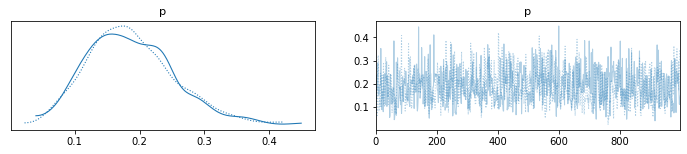

In [ ]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data)

###Problem 5

In [22]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):
    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu, 1/tau) where mu has a prior of Normal(m, s), 
    and tau has a prior of Gamma(alpha, beta). Set up a PyMC3 model for this 
    situation and sample from the poterior n times. Plot the trace plots for 
    mu and tau, and return the expected value of the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
      # Define the priors
      mu = pm.Normal('mu', mu=m, sigma=s)
      tao = pm.Gamma('tao', alpha=alpha, beta=beta)

      # Define the likelihood of data
      y = pm.Normal('y', mu=mu, sigma=(1/tao), observed=observed_heights)

      # Sample from the posterior
      trace = pm.sample(n)
      az.plot_trace(trace)

      # Calculate and return the mean
      new_p = trace['mu']
      mean = new_p.mean()

    return mean
    

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


180.2495828648002

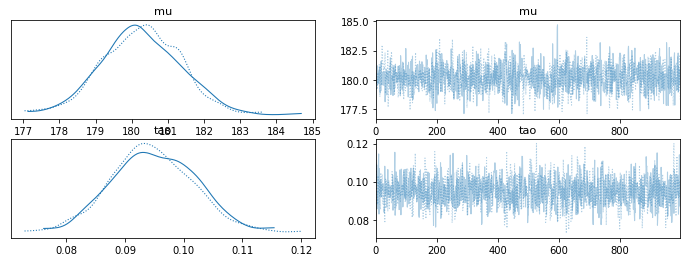

In [ ]:
heights = np.random.normal(180,10,100)
height_model(heights)